In [5]:
library(ggplot2)
library(ggseqlogo)
library(rtracklayer)
library(patchwork)

library(GenomicRanges)
library(readr)
library(magrittr)
library(dplyr)


In [6]:
BiocManager::install("BSgenome.Hsapiens.UCSC.hg18")

'getOption("repos")' replaces Bioconductor standard repositories, see
'?repositories' for details

replacement repositories:
    CRAN: https://cran.r-project.org


Bioconductor version 3.12 (BiocManager 1.30.18), R 4.0.3 (2020-10-10)

Installing package(s) 'BSgenome.Hsapiens.UCSC.hg18'

Old packages: 'BiocManager', 'bslib', 'cpp11', 'DT', 'fontawesome', 'gmp',
  'IRkernel', 'mgcv', 'nlme', 'openssl', 'ragg', 'RSQLite', 'Rttf2pt1',
  'shiny', 'vctrs', 'XML', 'ade4', 'callr', 'car', 'cli', 'clue',
  'colourpicker', 'data.table', 'dbscan', 'devtools', 'digest', 'dplyr',
  'e1071', 'fracdiff', 'ggraph', 'ggsignif', 'graphlayouts', 'hardhat',
  'httpuv', 'igraph', 'jsonlite', 'lava', 'leiden', 'lifecycle', 'lme4',
  'lpSolveAPI', 'maps', 'maptools', 'markdown', 'MASS', 'Matrix',
  'MatrixModels', 'minqa', 'MPV', 'openxlsx', 'parsedate', 'pbdZMQ', 'pcaPP',
  'pillar', 'pkgload', 'polyclip', 'processx', 'ps', 'R.utils', 'RcppAnnoy',
  'RcppGSL', 'RCurl', 'readr', 'recipes', 'reticulate', 'rla

In [7]:
library(BSgenome.Hsapiens.UCSC.hg19)
library(BSgenome.Hsapiens.UCSC.hg38)
library(BSgenome.Hsapiens.UCSC.hg18)

genome19 = BSgenome.Hsapiens.UCSC.hg19
genome38 = BSgenome.Hsapiens.UCSC.hg38
genome18 = BSgenome.Hsapiens.UCSC.hg18






Attaching package: ‘BSgenome.Hsapiens.UCSC.hg18’


The following object is masked from ‘package:BSgenome.Hsapiens.UCSC.hg38’:

    Hsapiens


The following object is masked from ‘package:BSgenome.Hsapiens.UCSC.hg19’:

    Hsapiens




In [9]:
#config = read.table("./GM12878_corrected_scaled.tsv", header=T, stringsAsFactors=F, sep='\t')
#config

#region_coorda


## Load Data

In [10]:
# one bigwig at a time, any number of peaks
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

# one bigwig, one peak (GRanges object)
get_importance_from_bigwig <- function(bigwig_path, peak, genome) {
    stopifnot(length(peak)==1)
    
    # get DNA sequence
    sequence = genome
    #sequence = genome[[as.vector(seqnames(peak))]][start(peak):end(peak)]
    #sequence = DNAString("G")
    m = matrix(0, length(sequence), 4)
    colnames(m) = c("A", "C", "G", "T")
    m[cbind(seq(length(sequence)), as.vector(matrix(sequence)))] = get_matrix_from_bigwig(bigwig_path, peak)

    t(m)
}

In [11]:
GRangesFromDataFrames<-function(dataframe){with(dataframe,GRanges(IRanges(start=start,end=end),seqnames=seqnames,strand=strand,dataframe%>%dplyr::select(-strand,-start,-end,-seqnames)))}

calculate_total_value_and_length <- function(bw_path,region){
    total_value = as.integer(sum(as.vector(get_matrix_from_bigwig(bw_path, region))))
    length = length(as.vector(get_matrix_from_bigwig(bw_path, region)))
    df = data.frame(total_value=total_value,length=length)
    df
}

calculate_normalization_value <- function(bw_path,peaks_path,mc.cores=40){
        peaks_df = read_tsv(peaks_path,
                         col_names=c("seqnames","start","end","name","score","strand","p","q","x","summit"),
                         show_col_types = FALSE)
        peaks_df['strand']<-'*'
        valid_chrs = c('chr1',"chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
                                 "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20",
                                 "chr21","chrX","chrY")
        peaks_df[peaks_df[["seqnames"]] %in% valid_chrs,]
        peaks_gr = GRangesFromDataFrames(peaks_df)

        peaks_gr = keepSeqlevels(peaks_gr, c('chr1',"chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10",
                                 "chr11","chr12","chr13","chr14","chr15","chr16","chr17","chr18","chr19","chr20",
                                 "chr21","chrX"), pruning.mode="coarse")

        print(bw_path)
        1:length(peaks_gr) %>% mclapply(function(i){
                                        calculate_total_value_and_length(bw_path,peaks_gr[i])
                                        },mc.cores=mc.cores
                                        ) %>% bind_rows() -> normalization_df

        sum(normalization_df["total_value"])/sum(normalization_df["length"])
}



## Plot types

In [12]:
TITLE_SZ = 16

### Importance

In [13]:
plot_seq <- function(m, ymin=NULL, ymax=NULL, clip=F) {
    mat = m
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            mat[mat<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            mat[mat>ymax] = ymax
        }
    }
    

    p = ggseqlogo(mat, method='custom', seq_type='dna') 
    
    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(ymin, ymax)) + 
         expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=c(ymin, ymax)) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p = p 
    #+ theme(axis.ticks.y = element_blank(),axis.text.y = element_blank())

    p
}

plot_importance <- function(bigwig_path, region, genome, ylabel, ymin=NULL, ymax=NULL, clip=F) {
    plot_seq(get_importance_from_bigwig(bigwig_path, region, genome), ymin=ymin, ymax=ymax, clip=clip) +
        ylab(gsub("\\\\n", "\n", ylabel)) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5, vjust=0.5))
}

### Single Track

In [14]:
plot_single_vals <- function(v, ymin=NULL, ymax=NULL, 
                             clip=F, fill=T, 
                             col='#37ada2',x_width) {
    vals = v
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            vals[vals<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            vals[vals>ymax] = ymax
        }
    }
    
    p = ggplot(data.frame(x=seq(length(vals)), y=vals), aes(x=x,y=y)) 
    
    if (fill==T) {
        p = p + geom_area(fill=col)
    }
    
    else {
        p = p + geom_line(col=col)
    }
    
    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(ymin, ymax)) + 
         expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=pretty(c(0, max(max(vals1),max(vals2))),n=2,min.n=1)) +
         #scale_y_continuous(breaks=c(0, ymax)) +
       
         #coord_cartesian(ylim=c(0, ceiling(max(vals)))) + 
         #expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=pretty(c(0, max(vals)),n=2,min.n=1)) +
         #scale_y_continuous(breaks=c(0, ceiling(max(vals)))) +
         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p = p + theme(axis.text.y = element_text(size=14))
    
    p
}

plot_single <- function(bigwig_path, region, 
                        ylabel, ymin=NULL, ymax=NULL, 
                        fill=T, col='#37ada2', clip=F,
                        normalize = FALSE,normalization_value=None, normalization_region,normalization_file) {
    v1 = as.vector(get_matrix_from_bigwig(bigwig_path, region))
    if (normalize){
        #normalization_value = calculate_normalization_value(normalization_file,normalization_region)
        print(max(v1))
        print(normalization_value)
        v1=(v1/normalization_value)
        print(max(v1))
    }
    plot_single_vals(v1, ymin=ymin, ymax=ymax, clip=clip, fill=fill, col=col, x_width=width(region)) +
        ylab(gsub("\\\\n", "\n", ylabel)) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5,  vjust=0.5))
}

In [15]:
## scale


In [16]:
plot_scale_vals <- function(v, col='#a9d1ac') {
    vals = v
    
    p = ggplot(data.frame(x=seq(length(vals)), y=0), aes(x=x,y=y)) 
    
   
    p = p + geom_line(col=col)

    p = (p + 
         theme_classic() + 
         expand_limits(x=0, y=0) +
         scale_x_continuous(breaks=pretty(c(0, length(vals)/10),n=2,min.n=1)) +
         theme(axis.ticks.y = element_blank(), axis.text.y = element_blank(),axis.title = element_blank(),axis.line.y = element_blank())
        ) 
    
    p
}

plot_scale <- function(bigwig_path, region, ylabel, ymin=NULL, ymax=NULL, fill=T, col='#37ada2', clip=F) {
    plot_scale_vals(as.vector(get_matrix_from_bigwig(bigwig_path, region)), col=col) +
        ylab(ylabel) +
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0.5, vjust=0.5))
}

### Stranded Track

In [17]:
plot_stranded_vals <- function(v1, v2, ymin=NULL, 
                               ymax=NULL, clip=F, 
                               col1='blue', col2='orange') {
    vals1 = v1
    vals2 = v2
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        if (!is.null(ymin)) {
            vals1[vals1<ymin] = ymin
            vals2[vals2<ymin] = ymin
        }
        
        if (!is.null(ymax)) {
            vals1[vals1>ymax] = ymax
            vals2[vals2>ymax] = ymax
        }
    }
    
    p = ggplot(data.frame(x=seq(length(vals1)), y1=vals1, y2=vals2)) +
        geom_area(aes(x=x, y=y1), fill=col1, alpha = 0.8) +
        geom_area(aes(x=x, y=y2), fill=col2, alpha = 0.8) 

    p = (p + 
         theme_classic() + 
         coord_cartesian(ylim=c(ymin, ymax)) + 
         expand_limits(x=0, y=0) +
         #scale_y_continuous(breaks=pretty(c(0, max(max(vals1),max(vals2))),n=2,min.n=1)) +
         scale_y_continuous(breaks=c(0, ymax)) +

         theme(axis.ticks.x = element_blank(), axis.text.x = element_blank(),axis.title.x = element_blank(),axis.line.x = element_blank()))
    
    p

}

plot_stranded <- function(bigwig_prefix, region, ylabel, ymin=NULL, ymax=NULL,
                          clip=F, col1='blue', col2='orange',
                          normalize = FALSE,normalization_region,normalization_file_prefix) {
    # plus and minus should be bigwig_prefix + "plus.bw" and bigwig_prefix + "minus.bw"
    
    v1 = as.vector(get_matrix_from_bigwig(paste(bigwig_prefix, "_plus.bw", sep='') , region))
    v2 = as.vector(get_matrix_from_bigwig(paste(bigwig_prefix, "_minus.bw", sep='') , region))
    if (normalize){
        normalization_value = calculate_normalization_value(paste(normalization_file_prefix, "pos.bw", sep=''),normalization_region)
        v1=(v1/normalization_value)
    } 
    if (normalize){
        normalization_value = calculate_normalization_value(paste(normalization_file_prefix, "neg.bw", sep=''),normalization_region)
        v2=(v2/normalization_value)
    } 
    plot_stranded_vals(v1, v2, ymin=ymin, ymax=ymax, clip=clip, col1=col1, col2=col2) + 
        ylab(ylabel) + 
        theme(axis.title.y = element_text(angle=0, size=TITLE_SZ, hjust=0)) +
        theme(axis.text.y = element_text(size=14))
}

## Generate plots from config

In [107]:
#my_list <- list("#E00FEE", "#E00FEE", "#7B241C", "red", "#4A235A", "#4A235A", "#239B56", "blue")
#my_list <- list("#4A235A", "#4A235A", "#239B56", "blue")
#my_list <- list("#E00FEE", "#E00FEE", "null", "#458B00", "null", "#0000FF", "null", "#A52A2A", "null", "#A52A2A", "null", "#A52A2A", "null")

generate_plots <- function(config, region, genome) {
    plots = list()
    
    # configure for different relative heights for single, stranded and dynseq tracks
    REL_HEIGHTS = c(single=1, stranded=1, dynseq=1.5, scale =0.5)
    
    heights = c()
    
    for (i in seq(nrow(config))) {
        print(config$sample[i])
        if (config$type[i] == "dynseq") {
            
            sequence = genome[[as.vector(seqnames(region))]][start(region):end(region)]
            
            if (config$genome[i] == "hg18"){
            genome = genome18
            if (grepl("REF", config$sample[i], fixed = TRUE)){
                print(sequence[104419735-start(region)+2])
                sequence[104419735-start(region)+2] = DNAString("C")
                print(sequence[104419735-start(region)+2])
                }
            }
            
  
            plots[[i]] = plot_importance(config$path[i], region, sequence, config$sample[i], ymin=as.double(config$Min[i]), ymax=as.double(config$Max[i]), clip=T)            
        }
        
        else if (config$type[i] == "single") {
            #print(i)
            #print(my_list[i])
            #print(paste("#",config$Color[i],sep=""))
            plots[[i]] = plot_single(config$path[i], region, 
                                     config$sample[i],
                                     col=paste("#",config$Color[i],sep=""),
                                     ymin=as.double(config$Min[i]), ymax=as.double(config$Max[i]),
                                     normalization_value=NA,
                                     normalize=FALSE,
                                     normalization_region=config$normalization_region[i],
                                     normalization_file=config$normalization_file[i]
                                    )
            
        }
        
        else if (config$type[i] == "stranded") {
            plots[[i]] = plot_stranded(config$path[i], region, config$sample[i],
                                     normalize=config$normalize[i],
                                     ymin=as.double(config$Min[i]), ymax=as.double(config$Max[i]),
                                     normalization_region=config$normalization_region[i],
                                     normalization_file=config$normalization_file[i])
        }
        else if (config$type[i] == "scale") {
            plots[[i]] = plot_scale(config$path[i], region, config$sample[i])
        }
        
        heights = c(heights, REL_HEIGHTS[config$type[i]])        
        
    }
    
    main = wrap_plots(plots, heights=heights)
    main
}

## Plotting
    

In [127]:
#config = read.table("configs/chip_bqtls.tsv", header=T, stringsAsFactors=F, sep='\t')
#config = read.table("configs/all_bqtls-unzoom.tsv", header=T, stringsAsFactors=F, sep='\t')
#config = read.table("configs/all_dsqtls_unzoom.tsv", header=T, stringsAsFactors=F, sep='\t')
config = read.table("configs/all_dsqtls-zoom.tsv", header=T, stringsAsFactors=F, sep='\t')
#config = read.table("./configs/config_supp_gm.tsv", header=T, stringsAsFactors=F, sep='\t')

#config = read.table("configs/atac_bqtls.tsv", header=T, stringsAsFactors=F, sep='\t')
#config = read.table("configs/dnase_bqtls.tsv", header=T, stringsAsFactors=F, sep='\t')

config

sample,path,normalize,normalization_region,normalization_file,type,Min,Max,Scale,Color,genome
<chr>,<chr>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Enformer REF prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/dsqtl_preds_enformer_test/ref_output.bw,FALSE,None,None,single,0,3,None,8D4585,hg18
Enformer ALT prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/dsqtl_preds_enformer_test/alt_output.bw,FALSE,None,None,single,None,None,None,8D4585,hg18
ATAC REF prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/dsqtls_interpret_small//bigwigs/profile_ref.bw,FALSE,None,None,single,0,4,None,0E6655,hg18
ATAC ALT prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/dsqtls_interpret_small//bigwigs/profile_alt.bw,FALSE,None,None,single,None,None,None,0E6655,hg18
ATAC REF importance,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/dsqtls_interpret_small//bigwigs/count_shap_ref.bw,FALSE,None,None,dynseq,0,0.06,None,943126,hg18
ATAC ALT importance,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/ATAC_PE/GM12878/nautilus_runs/GM12878_03.01.2022_bias_128_4_1234_0.4_fold_0/dsqtls_interpret_small//bigwigs/count_shap_alt.bw,FALSE,None,None,dynseq,0,0.06,None,943126,hg18
DNase REF prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/dsqtls_interpret_small//bigwigs/profile_ref.bw,FALSE,None,None,single,0,0.4,None,21618C,hg18
DNase ALT prediction,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/dsqtls_interpret_small//bigwigs//profile_alt.bw,FALSE,None,None,single,None,None,None,21618C,hg18
DNase REF importance,/mnt/lab_data2/anusri/chrombpnet/results/chrombpnet/DNASE_SE/GM12878/nautilus_runs/GM12878_03.06.2022_bias_128_4_1234_0.8_fold_0/dsqtls_interpret_small//bigwigs/count_shap_ref.bw,FALSE,None,None,dynseq,0,0.06,None,943126,hg18


In [128]:
range="chr10:104418735-104420735"
#range="chr22:43720729-43721129"
cellline="dsqtl_200_flank_zoom"

file_name = paste(paste(cellline,range,sep="_"),".pdf",sep="")
file_name

[1] "dsqtl_200_flank_zoom_chr10:104418735-104420735.pdf"

[1] "chr10:104419635-104419835"
[1] "hello"
[1] "104419635"
[1] "104419835"
[1] "Enformer REF prediction"
[1] "Enformer ALT prediction"


Warning message in ggproto(NULL, CoordCartesian, limits = list(x = xlim, y = ylim), :
“NAs introduced by coercion”
Warning message in ggproto(NULL, CoordCartesian, limits = list(x = xlim, y = ylim), :
“NAs introduced by coercion”


[1] "ATAC REF prediction"
[1] "ATAC ALT prediction"


Warning message in ggproto(NULL, CoordCartesian, limits = list(x = xlim, y = ylim), :
“NAs introduced by coercion”
Warning message in ggproto(NULL, CoordCartesian, limits = list(x = xlim, y = ylim), :
“NAs introduced by coercion”


[1] "ATAC REF importance"
1-letter DNAString object
seq: G
1-letter DNAString object
seq: C


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "ATAC ALT importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "DNase REF prediction"
[1] "DNase ALT prediction"


Warning message in ggproto(NULL, CoordCartesian, limits = list(x = xlim, y = ylim), :
“NAs introduced by coercion”
Warning message in ggproto(NULL, CoordCartesian, limits = list(x = xlim, y = ylim), :
“NAs introduced by coercion”


[1] "DNase REF importance"
1-letter DNAString object
seq: G
1-letter DNAString object
seq: C


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



[1] "DNase ALT importance"


Warning message:
“`guides(<scale> = FALSE)` is deprecated. Please use `guides(<scale> = "none")` instead.”
Coordinate system already present. Adding new coordinate system, which will replace the existing one.



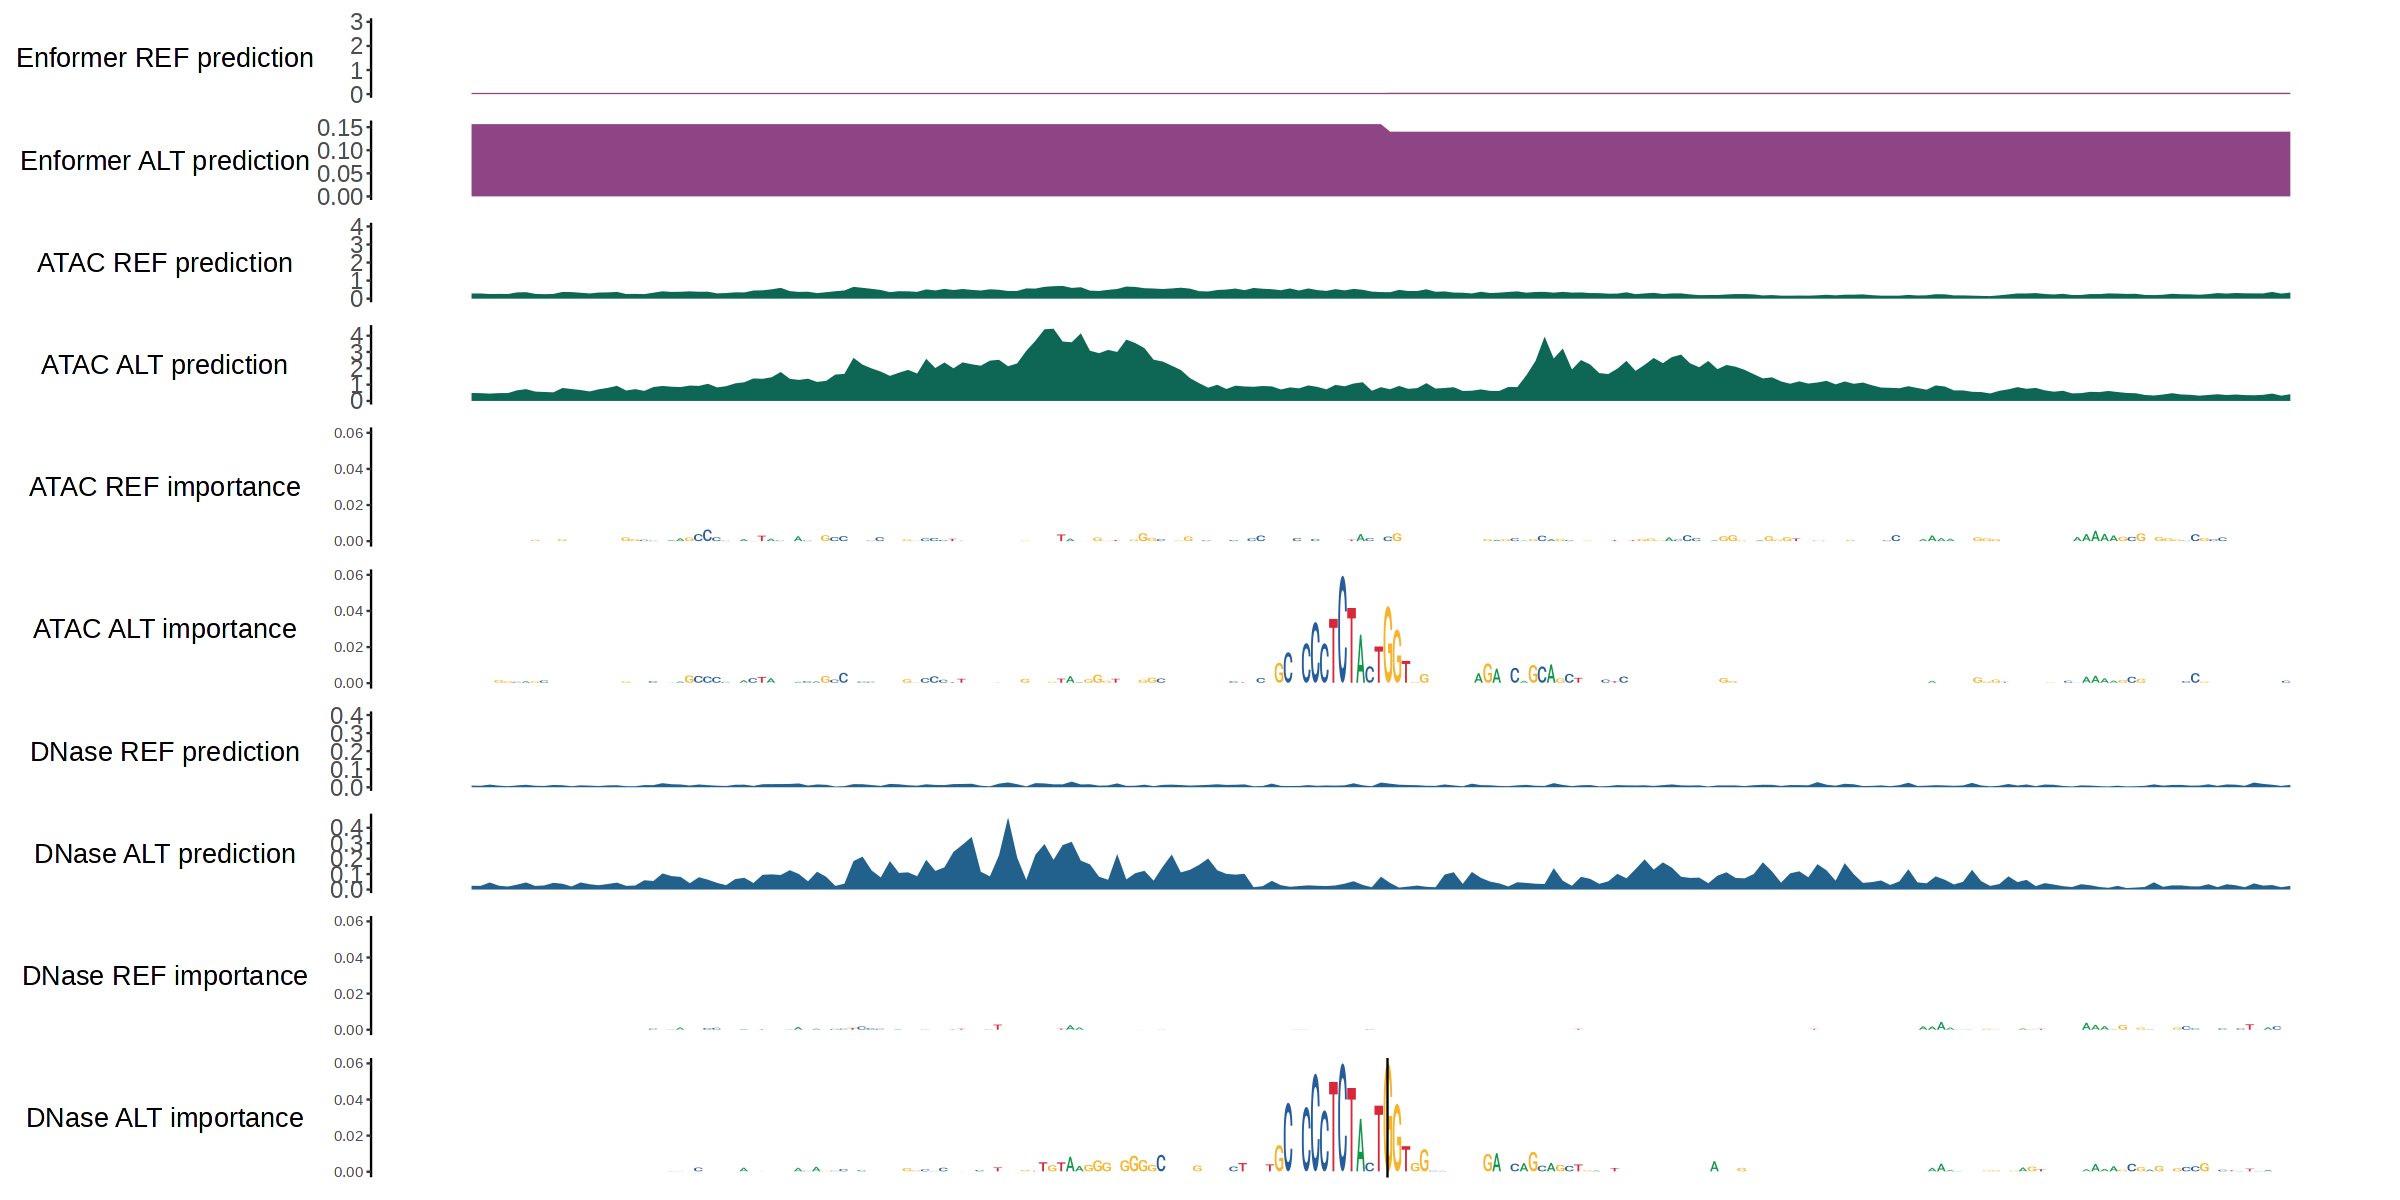

In [129]:

options(repr.plot.width = 20, repr.plot.height = nrow(config))
mid1=104419735
mid2=104419735
flank1=100
flank2=100

#flank1=200
#flank2=200
#file_name="unzoom_bqtl.pdf"
start1=mid1-flank1
end1=mid1+flank2


range=paste("chr10:",start1,"-",end1, sep="")
print(range)
print("hello")
REGION = GRanges(range)

flank1=100
flank2=100
start1=as.character(mid2-flank1)
end1=as.character(mid2+flank2)

range=paste("chr10:",start1,"-",end1, sep="")
#range="chr22:44116699-44116910"
REGION2 = GRanges(range)

print(start1)
print(end1)
p1 = generate_plots(config, REGION, genome18) + geom_vline(xintercept=flank1+2)
#p2 = generate_plots(config[1:2,], REGION2, genome19)

p1

In [130]:
#p1/p2
#p2
p = p1
#p=cowplot::plot_grid(p1, p2, ncol = 1, align = "v", rel_heights = c(0.5, 1.0))
ggsave(paste("subfigs/locus_plots/",file_name,sep=""), p, height=nrow(config), width=20, useDingbats=F)


In [17]:
#wrap_plots(ggplot() + theme_void() + annotate("segment", x=0, xend=0, y=0, yend=0.25),p,heights=c(10,10),widths=c(1,20),ncol=2)


In [18]:
#genome19[["chr22"]][44116810:44116810] + DNAString("G")
#genome19[["chr22"]][44116810:44116810]
ddp  =DNAString("GAA")

In [19]:
ddp[0:1] = DNAString("T")

In [20]:
ddp

3-letter DNAString object
seq: TAA

In [21]:
sessionInfo()

R version 4.0.3 (2020-10-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 18.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/libf77blas.so.3.10.3
LAPACK: /usr/lib/x86_64-linux-gnu/atlas/liblapack.so.3.10.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=C             
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] BSgenome.Hsapiens.UCSC.hg38_1.4.3 BSgenome.Hsapiens.UCSC.hg19_1.4.3
 [3] BSgenome_1.58.0                   Biostrings_2.58.0                
 [5] XVector_0.30.0                    dplyr_1.0.9                      
 [7] magrittr_2.0.3       